In [1]:

import sys
import os
sys.path.append("..")

import jax.numpy as jnp
import jax
import numpy as np
import matplotlib.pyplot as plt
from jax import grad, jit, vmap
import numpyro
from numpyro import distributions as dist
from numpyro import infer

from numpyro_ext import distributions as distx
from numpyro_ext import info, optim

numpyro.set_host_device_count(
    2
)  # For multi-core parallelism (useful when running multiple MCMC chains in parallel)
numpyro.set_platform("cpu")  # For CPU (use "gpu" for GPU)
jax.config.update(
    "jax_enable_x64", True
)
#jax.config.update('jax_disable_jit', True)

from jaxoplanet import light_curves, orbits
from jaxoplanet.light_curves import limb_dark_light_curve
import arviz as az
import corner

from eclipsoid.light_curve import legacy_oblate_lightcurve, compute_bounds
import os
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=2"

oblate_lightcurve = jit(legacy_oblate_lightcurve)
grad = jit(jax.jacrev(legacy_oblate_lightcurve))

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


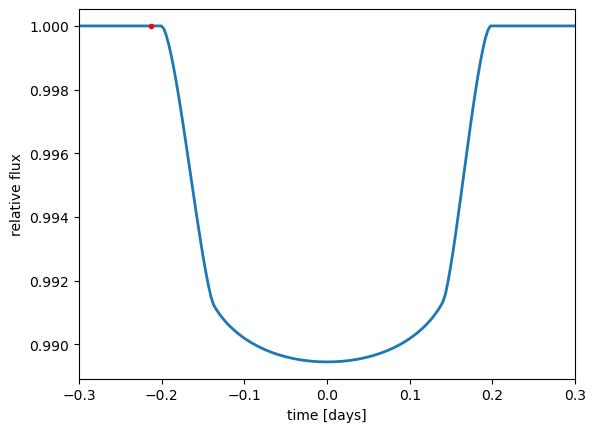

In [2]:
#Fiducial planet parameters:
params = {'period':300.456,
          'radius':jnp.sqrt(0.1**2/(1-0.1)),
          'u':jnp.array([0.3,0.2]),
          'f':0.1,
          'bo':0.65,
          'theta':.6,
          'duration': 0.4
}
# The light curve calculation requires an orbit

# Compute a limb-darkened light curve using starry
t = jnp.linspace(-0.3, 0.3, 200)
lc = oblate_lightcurve(params,t)

plt.plot(t, lc, color="C0", lw=2)
plt.plot(t[29], lc[29], 'r.')
plt.ylabel("relative flux")
plt.xlabel("time [days]")
_ = plt.xlim(t.min(), t.max())

In [3]:
orbit = orbits.TransitOrbit(period=params['period'], radius=params['radius'], impact_param=params['bo'], duration=params['duration'])
xo, yo = orbit.relative_position(t)[0].magnitude,orbit.relative_position(t)[1].magnitude

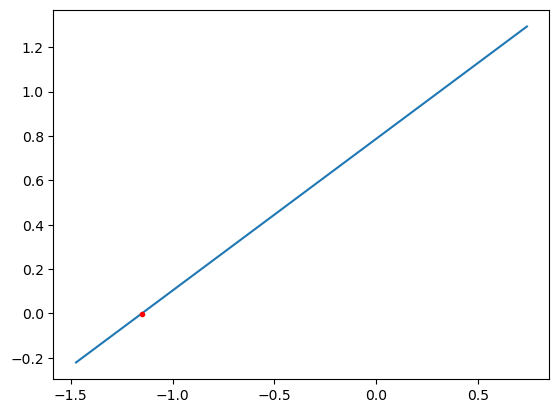

In [4]:
xo_rot, yo_rot = xo*jnp.cos(params['theta'])-yo*jnp.sin(params['theta']), xo*jnp.sin(params['theta'])+yo*jnp.cos(params['theta'])
plt.plot(xo_rot, yo_rot, 'C0')
plt.plot(xo_rot[29], yo_rot[29], 'r.')

In [5]:
%%timeit
lc = oblate_lightcurve(params,t)

2.22 ms ± 11.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [6]:
%%timeit
grads = grad(params, t)

295 ms ± 10.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


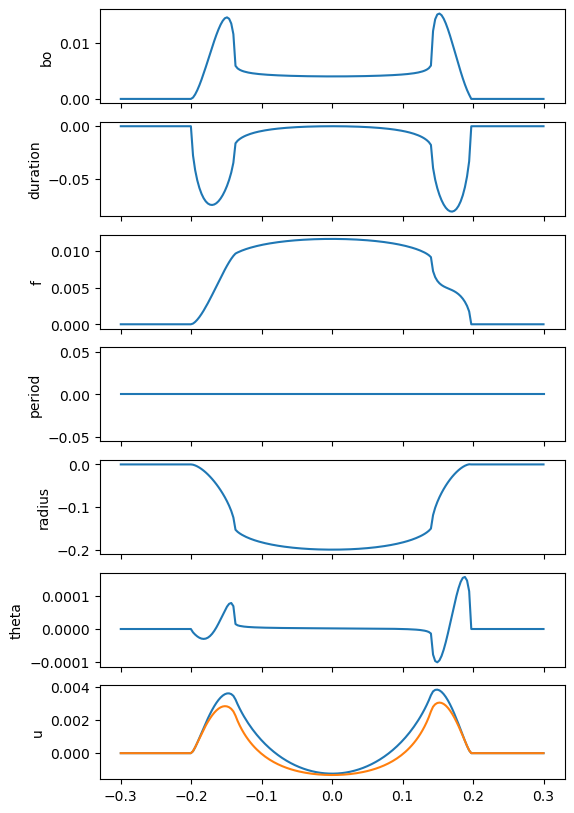

In [7]:
grads = grad(params, t)
_, axes = plt.subplots(len(grads.keys()), 1, figsize=(6, 10), sharex=True)
for n, key in enumerate(grads.keys()):
    axes[n].plot(t, grads[key])
    axes[n].set_ylabel(key)

{'period': 7.704045333151538, 't0': 1.0, 'radius': 0.1, 'bo': 0.8, 'u': Array([0.3, 0.2], dtype=float64), 'f': 0.3, 'theta': 0.6108652381980153, 'duration': 0.12}


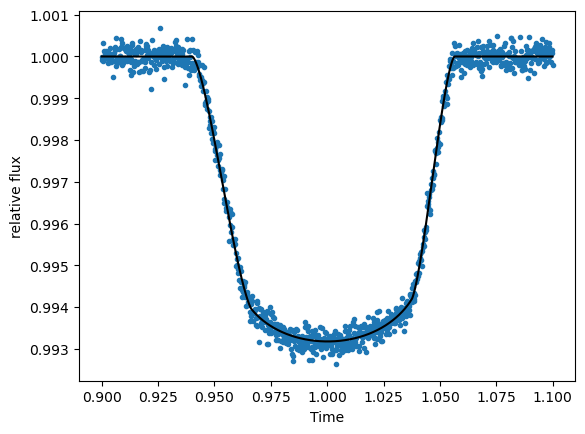

In [8]:
np.random.seed(11)
period_true = np.random.uniform(5, 20)
t = np.linspace(0.9,1.1,1000)
yerr = 200*1e-6

true_params = {'period':period_true,
               't0':1.0,
                'radius':0.1,
                'bo':0.8,
                'u':jnp.array([0.3, 0.2]),
                'f':0.3,
                'theta':np.radians(35),
                'duration': 0.12
} 

print(true_params)

# Compute a limb-darkened light curve using starry
lc_true = oblate_lightcurve(true_params, t-true_params['t0'])

lc = lc_true + yerr*np.random.normal(size=len(t))

ax = plt.subplot()
ax.plot(t, lc, 'C0.')
ax.plot(t, lc_true, color='k')
ax.set_ylabel("relative flux")
ax.set_xlabel("Time");

In [9]:
def model(t, yerr, y=None):
    # If we wanted to fit for all the parameters, we could use the following,
    # but we'll keep these fixed for simplicity.
    
    #log_duration = numpyro.sample("log_duration", dist.Uniform(jnp.log(0.08), jnp.log(0.2)))
    #b = numpyro.sample("b", dist.Uniform(0.0, 1.0))

    #log_jitter = numpyro.sample("log_jitter", dist.Normal(jnp.log(yerr), 1.0))
    r_circ = numpyro.sample("r_circ", dist.Uniform(0.01, 0.2))
    u = numpyro.sample("u", distx.QuadLDParams())
    bo = numpyro.sample("bo", dist.Uniform(0.0,1.))
    
    #parametrize f, theta using a unit disk
    hk = numpyro.sample("hk", distx.UnitDisk())
    f = numpyro.deterministic("f", (hk[0] ** 2 + hk[1] ** 2)/2)
    theta = numpyro.deterministic("theta", jnp.arctan2(hk[1], hk[0])/2)
    
    # The duration
    log_d = numpyro.sample("log_d", numpyro.distributions.Normal(jnp.log(0.12), 0.01))
    duration = numpyro.deterministic("duration", jnp.exp(log_d))
    
    params = {
        'period':period_true,
        't0': 1.0,
        "radius": jnp.sqrt(r_circ**2/(1-f)),
        'bo':bo,
        'u': u,
        'f':f, 
        'theta':theta,
        'duration': duration
    }
    y_pred = oblate_lightcurve(params, t-params['t0'])
    numpyro.deterministic("light_curve", y_pred)
    numpyro.sample(
        "flux",
        dist.Normal(y_pred, jnp.sqrt(yerr**2) #+ jnp.exp(2 * log_jitter))
                    ),
        obs=y,
    )

In [10]:
n_prior_samples = 3000
prior_samples = numpyro.infer.Predictive(model, num_samples=n_prior_samples)(
    jax.random.PRNGKey(0), t, yerr
)

# Let's make it into an arviz InferenceData object.
# To do so we'll first need to reshape the samples to be of shape (chains, draws, *shape)
converted_prior_samples = {
    f"{p}": np.expand_dims(prior_samples[p], axis=0) for p in prior_samples
}
prior_samples_inf_data = az.from_dict(converted_prior_samples)

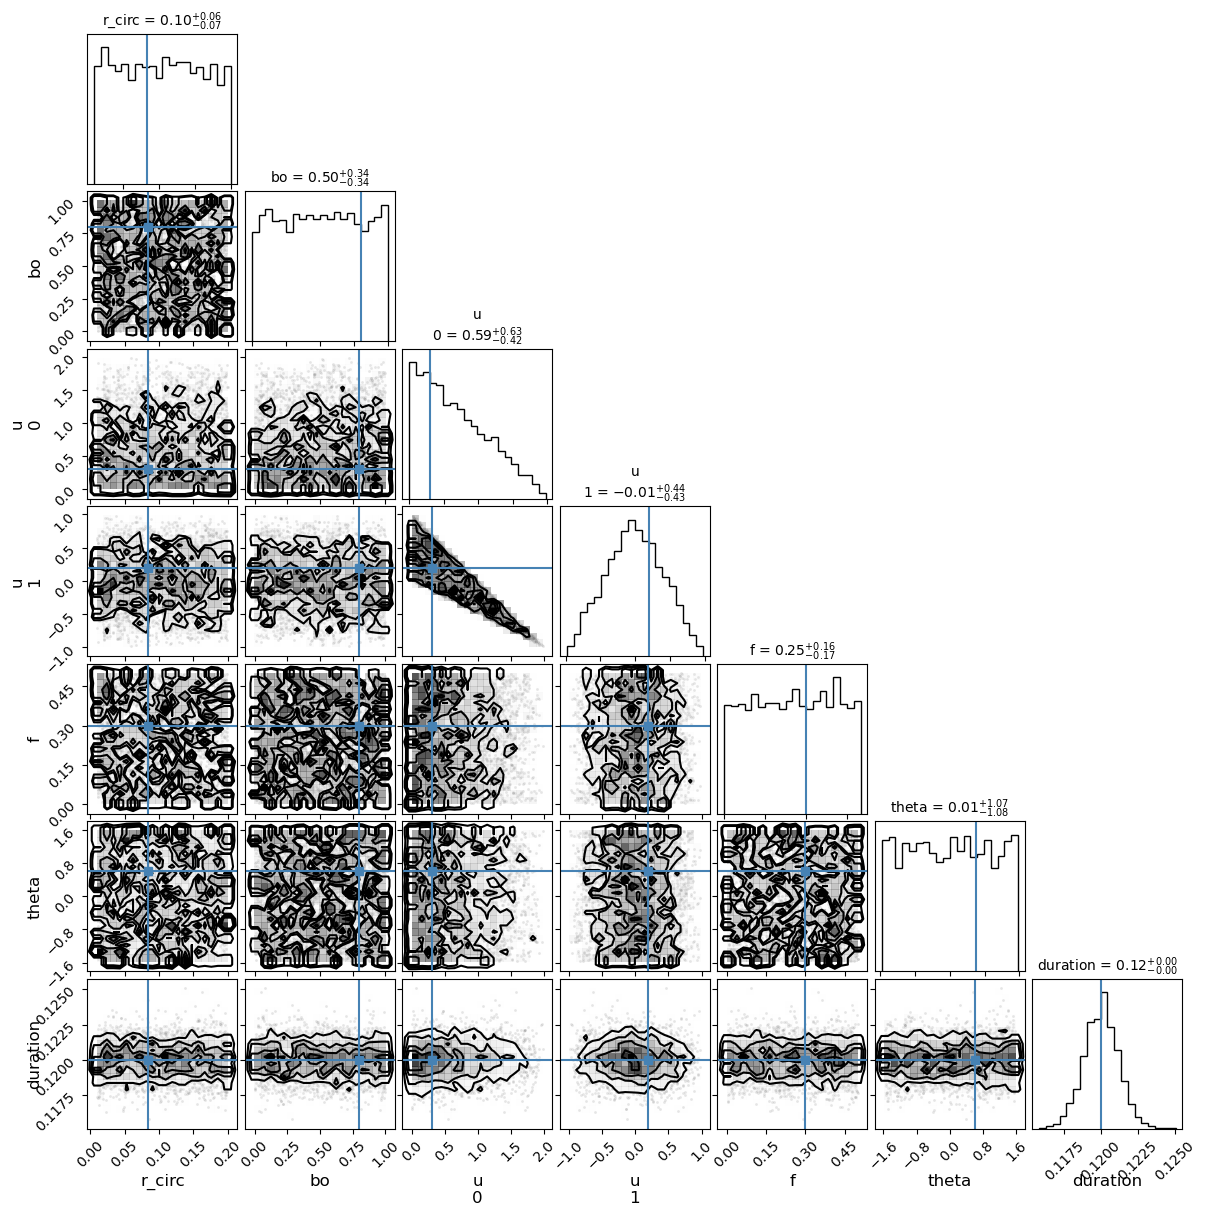

In [11]:
# Plot the corner plot
fig = plt.figure(figsize=(12, 12))
_ = corner.corner(
    prior_samples_inf_data,
    fig=fig,
    var_names=['r_circ', 'bo', 'u', 'f', 'theta', 'duration'],
    truths=[jnp.sqrt(true_params['radius']**2*(1-true_params['f'])), true_params['bo'], true_params['u'][0], true_params['u'][1], true_params['f'], true_params['theta'], true_params['duration']],
    show_titles=True,
    title_kwargs={"fontsize": 10},
    label_kwargs={"fontsize": 12},
)

### Oblate MCMC Fit

In [12]:
init_params = {'r_circ':jnp.sqrt(true_params['radius']**2*(1-true_params['f'])),
               'u':jnp.array([0.1, 0.2]),
                'bo':0.6,
                'log_d': jnp.log(0.115),
                'hk':jnp.array([jnp.sqrt(0.5)*jnp.sin(jnp.radians(20)), jnp.sqrt(0.5)*jnp.cos(jnp.radians(20))])
               
}

In [13]:
import numpyro_ext.distributions, numpyro_ext.optim


run_optim = numpyro_ext.optim.optimize(
        model,
        optimizer=numpyro.optim.Adam(step_size=0.1),
        init_strategy=numpyro.infer.init_to_value(values=init_params),
        num_steps=100,
        return_info=True
    )

opt_params, status = run_optim(jax.random.PRNGKey(2), t, yerr, y=lc)

In [14]:
status

In [15]:
true_params

{'period': 7.704045333151538,
 't0': 1.0,
 'radius': 0.1,
 'bo': 0.8,
 'u': Array([0.3, 0.2], dtype=float64),
 'f': 0.3,
 'theta': 0.6108652381980153,
 'duration': 0.12}

In [16]:
opt_params

{'r_circ': Array(0.08363451, dtype=float64),
 'u': Array([0.28905399, 0.26576739], dtype=float64),
 'bo': Array(0.79358695, dtype=float64),
 'hk': Array([0.55717293, 0.61521228], dtype=float64),
 'log_d': Array(-2.11275552, dtype=float64),
 'duration': Array(0.12090435, dtype=float64),
 'f': Array(0.34446391, dtype=float64),
 'flux': Array([0.99999414, 0.99992348, 0.99988499, 1.00032419, 0.99993622,
        0.99999809, 1.00014041, 0.99999599, 1.00009191, 1.0001402 ,
        0.99996037, 1.00004226, 0.99997238, 1.00000762, 0.99993031,
        0.99985456, 1.00009444, 0.99987525, 0.99989696, 1.00021107,
        0.99985764, 0.99993357, 1.00004738, 0.99990734, 0.99988061,
        1.00002675, 0.99950351, 0.99989799, 1.00009424, 1.00015053,
        1.0002216 , 1.00043177, 0.99976238, 0.99985207, 0.99987719,
        0.99996133, 0.99990222, 0.99995889, 1.00018738, 0.99986453,
        1.0000016 , 1.00000221, 1.00040802, 1.00021741, 0.99978758,
        0.99991116, 1.00032921, 0.99990985, 0.9998503

In [17]:
opt_params['light_curve'].min()

Array(0.99313959, dtype=float64)

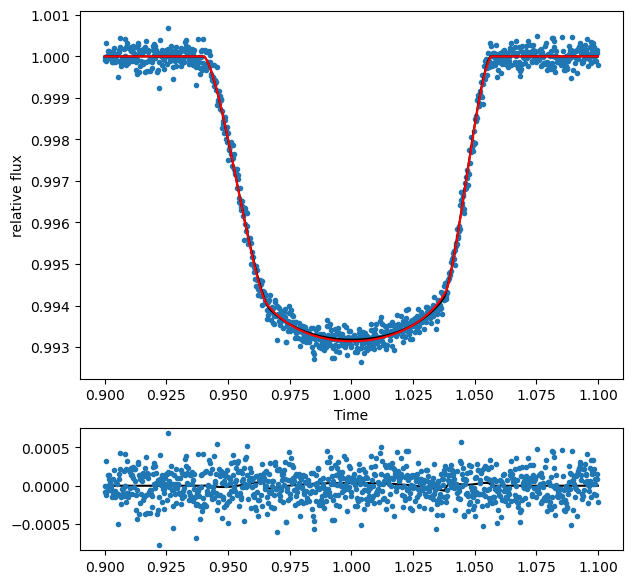

In [18]:
fig, (ax, ax1) = plt.subplots(2,1,figsize=(7,7), gridspec_kw={'height_ratios': [3, 1]})
ax.plot(t, lc, 'C0.')
ax.plot(t, lc_true, color='k')
ax.plot(t,opt_params['light_curve'], color='r')
ax1.plot(t, lc_true-opt_params['light_curve'], 'k-')
ax1.plot(t,lc-opt_params['light_curve'], 'C0.')
ax.set_ylabel("relative flux")
ax.set_xlabel("Time");

In [19]:
sampler_wn = infer.MCMC(
    infer.NUTS(
        model,
        target_accept_prob=0.8,
        dense_mass=True,
        init_strategy=infer.init_to_value(values=opt_params),
        regularize_mass_matrix=False,
        max_tree_depth=5
    ),
    num_warmup=1000,
    num_samples=2000,
    num_chains=2,
    progress_bar=True,
)
%time sampler_wn.run(jax.random.PRNGKey(11), t, yerr, lc)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

CPU times: user 1h 55min 9s, sys: 28 s, total: 1h 55min 37s
Wall time: 1h 4min 59s


In [20]:
inf_data_wn = az.from_numpyro(sampler_wn)
az.summary(inf_data_wn, var_names=['r_circ', 'bo', 'u', 'f', 'theta', 'duration'])

/Users/uqsdhola/opt/anaconda3/lib/python3.9/site-packages/arviz/utils.py:187: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
r_circ,0.085,0.001,0.083,0.086,0.000,0.000,40.0,87.0,1.01
bo,0.799,0.005,0.790,0.808,0.001,0.000,99.0,447.0,1.01
u[0],0.500,0.234,0.076,0.812,0.041,0.029,34.0,95.0,1.02
u[1],-0.011,0.264,-0.355,0.477,0.046,0.033,34.0,100.0,1.02
f,0.285,0.037,0.233,0.371,0.004,0.003,118.0,194.0,1.06
theta,0.656,0.218,0.319,1.034,0.051,0.036,19.0,217.0,1.11
duration,0.120,0.001,0.118,0.121,0.000,0.000,21.0,107.0,1.11


In [21]:
inf_data_wn.to_netcdf("average_radius_NUTS_200ppm.h5")

'average_radius_NUTS_200ppm.h5'

In [22]:
sampler_wn.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        bo      0.80      0.01      0.80      0.79      0.81     88.72      1.01
     hk[0]      0.19      0.32      0.21     -0.30      0.68     27.41      1.11
     hk[1]      0.66      0.07      0.67      0.55      0.75     32.31      1.12
     log_d     -2.12      0.01     -2.12     -2.13     -2.11     35.07      1.12
    r_circ      0.08      0.00      0.08      0.08      0.09     24.20      1.01
      u[0]      0.50      0.23      0.54      0.09      0.80     22.06      1.01
      u[1]     -0.01      0.26     -0.06     -0.36      0.44     22.49      1.02

Number of divergences: 229


/Users/uqsdhola/opt/anaconda3/lib/python3.9/site-packages/arviz/utils.py:187: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([[<AxesSubplot:title={'center':'r_circ'}>,
        <AxesSubplot:title={'center':'r_circ'}>],
       [<AxesSubplot:title={'center':'bo'}>,
        <AxesSubplot:title={'center':'bo'}>],
       [<AxesSubplot:title={'center':'u'}>,
        <AxesSubplot:title={'center':'u'}>],
       [<AxesSubplot:title={'center':'hk'}>,
        <AxesSubplot:title={'center':'hk'}>],
       [<AxesSubplot:title={'center':'duration'}>,
        <AxesSubplot:title={'center':'duration'}>]], dtype=object)

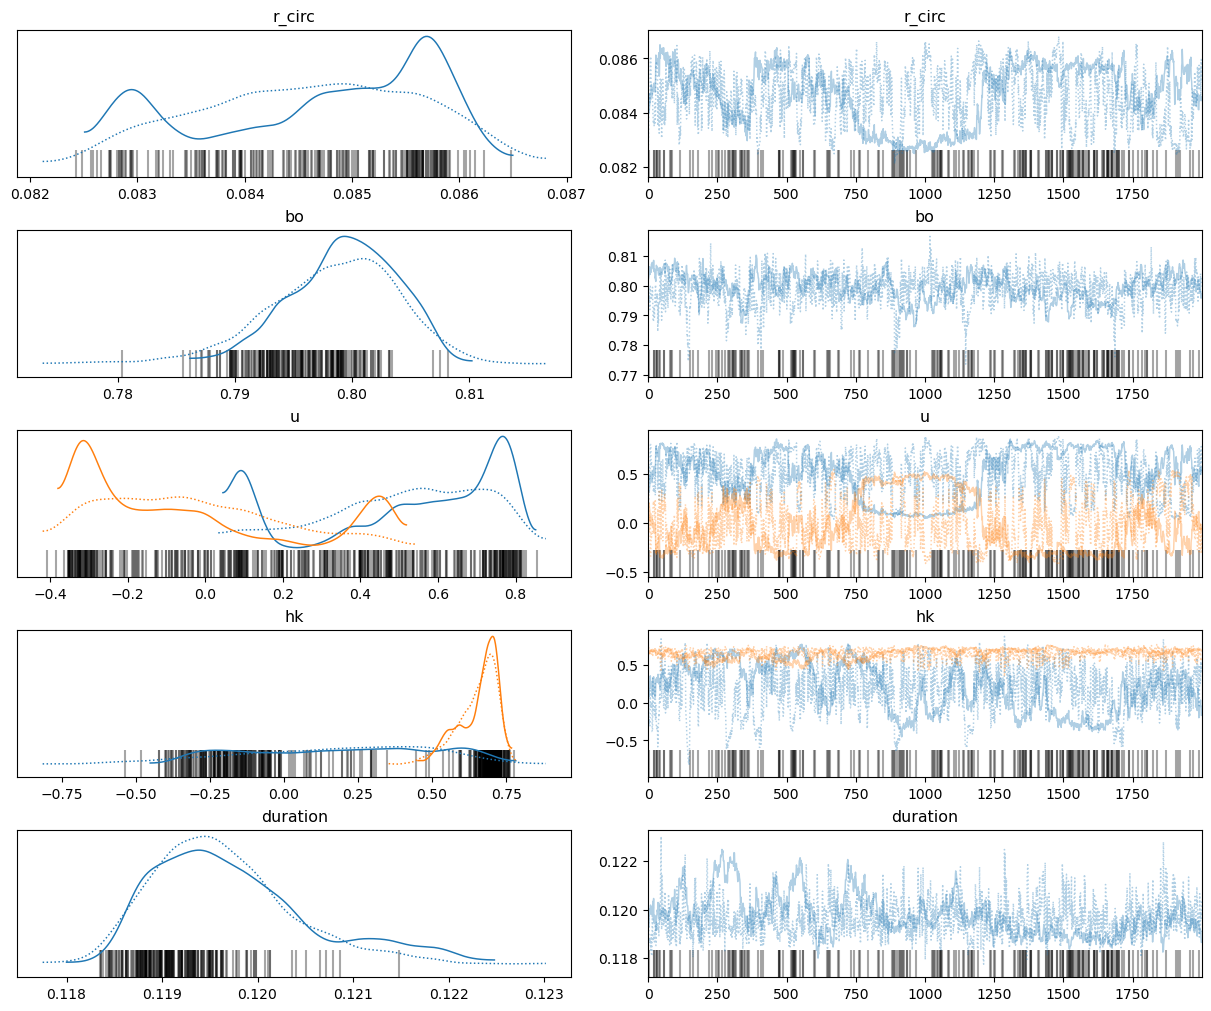

In [23]:
az.plot_trace(
    inf_data_wn,
    var_names=['r_circ', 'bo', 'u', 'hk', 'duration'],
    backend_kwargs={"constrained_layout": True},
)

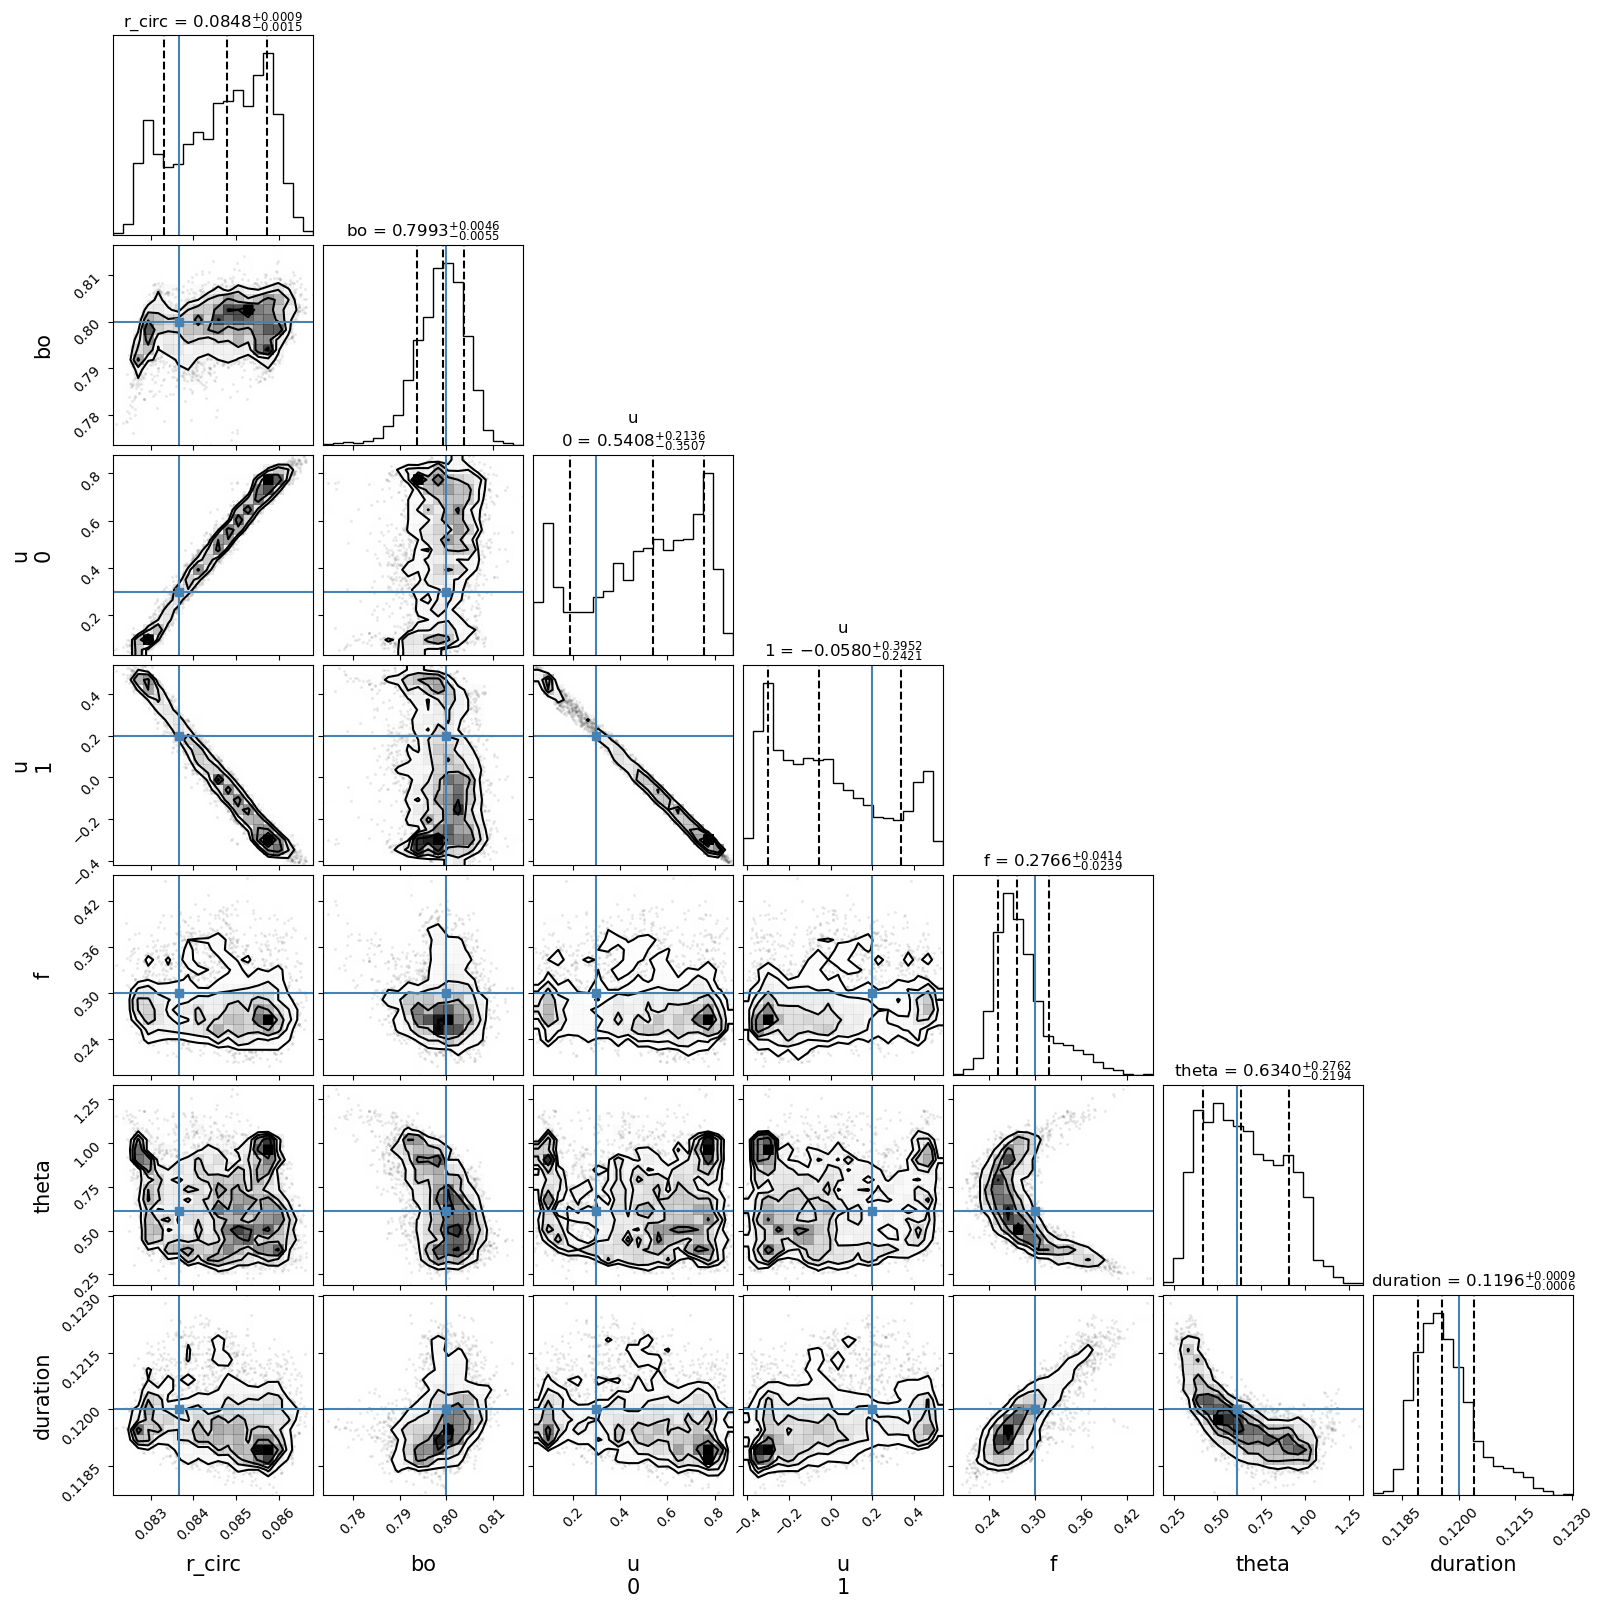

In [26]:
corner.corner(
    inf_data_wn,
    var_names=['r_circ', 'bo', 'u', 'f', 'theta', 'duration'],
    truths=[np.sqrt(true_params['radius']**2*(1-true_params['f'])), true_params['bo'], true_params['u'][0], true_params['u'][1], true_params['f'], true_params['theta'], true_params['duration']],
    show_titles=True,
    quantiles=[0.16, 0.5, 0.84],
    title_kwargs={"fontsize": 12},
    label_kwargs={"fontsize": 15},
    title_fmt=".4f",
);
#plt.savefig("100ppm_corner.png",dpi=300)

In [ ]:
import jax.numpy as jnp
jnp.radians(35)
jnp.degrees(0.575)

### Oblate Nested Sampling Fit

In [ ]:
from numpyro.contrib.nested_sampling import NestedSampler
from jaxns.prior_transforms.prior import UniformBase

In [ ]:
ns = NestedSampler(model,constructor_kwargs={'num_parallel_samplers':40})
ns.run(jax.random.PRNGKey(2), t, yerr, lc)

ns_samples = ns.get_samples(jax.random.PRNGKey(121), num_samples=10000)

In [ ]:
inf_data = az.from_dict(ns_samples, dropna=True)
az.summary(inf_data, var_names=["log_jitter", "log_r", "u1", "u2", "bo", "f", "theta"])


In [ ]:
import matplotlib as mpl
def plot_corner_diagnostics(samples, param_true):
    mpl.rcParams['font.size'] = 12
    ndim = len(samples.keys())
    # This is the empirical mean of the sample:
    value2 = np.mean(np.array(list(samples.values())),axis=1)
    #True
    value1 = param_true

    # Make the base corner plot
    # 68% et 95% quantiles 1D et levels in 2D
    figure = corner.corner(samples,quantiles=(0.025, 0.158655, 0.841345, 0.975), levels=(0.68,0.95), 
                        show_titles=True, title_kwargs={"fontsize": 12}, 
                        truths=param_true, truth_color='g', color='b'
                        );

    # Extract the axes
    axes = np.array(figure.axes).reshape((ndim, ndim))

    # Loop over the diagonal
    for i in range(ndim):
        ax = axes[i, i]
        ax.axvline(value2[i], color="r")
    
    # Loop over the histograms
    for idy in range(ndim):
        for idx in range(idy):
            ax = axes[idy, idx]
            ax.axvline(value2[idx], color="r")
            ax.axhline(value2[idy], color="r")
            ax.plot(value2[idx], value2[idy], "sr")

    plt.show()

In [ ]:
flat_samples = []
truth_list = []
for i,v in enumerate(varnames):
    flat_samples_i = ns_samples[v]
    flat_samples.append(flat_samples_i)
flat_samples = np.array(flat_samples)


In [ ]:
import corner
varnames = ["log_jitter", "log_r", "u1", "u2", "bo", "f", "theta"]
fig = corner.corner(flat_samples.T,range=[0.001,1,1,1,1,1,1],labels=varnames,truth=[yerr,jnp.log(true_params['radius']),true_params['u'][0],true_params['u'][1],true_params['bo'],true_params['f'],true_params['theta']])
plt.savefig('oblate_corner.png')

In [ ]:
[yerr,jnp.log(true_params['radius']),true_params['u'][0],true_params['u'][1],true_params['bo'],true_params['f'],true_params['theta']]
np.degrees(np.mean(flat_samples.T[:,6]))